# Prediction
Explanation:

## Import Packages

In [9]:
from importnb import Notebook
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from lightgbm import LGBMClassifier

## Dataframe import from 'FeatureEngineering'

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
with Notebook():
    from ModelPreparation import data

['Was Acquired' 'Made Acquisitions' 'Made Acquisitions, Was Acquired']
['Seed' 'No Funding' 'Venture - Series Unknown' 'Series A' 'Series B'
 'Convertible Note' 'Angel' 'Post-IPO Debt' 'Private Equity' 'Pre-Seed'
 'Grant' 'Series C' 'Series F' 'Series D' 'Post-IPO Secondary' 'Series E'
 'Post-IPO Equity']
3608 investors could not be found.
Recognition Rate: 91.04%
Total Entries with Degrees: 1663
Recognized Degrees: 1514
Series([], dtype: int64)
Remaining rows after dropping NaNs: 1513
Strongly correlated feature pairs:
Average Funding Size and Last Funding Amount with a correlation of 0.91
Average Time To Next Round and Months until First Round with a correlation of 0.87
Months between Founding and Acquisition and Was Acquired with a correlation of 0.92
Average Number of Portfolio Organizations by Investors and Average Number of Investments by Investors with a correlation of 0.93
Industry_data and analytics and Industry_artificial intelligence (ai) with a correlation of 0.84
min_linke

/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/FeatureEngineering.ipynb:1497: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  companies.fillna(0, inplace=True)
/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/ADA_Coding/Code/FeatureEngineering.ipynb:2529: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [4]:
data

,Number of Founders,Number of Employees,Number of Funding Rounds,Last Funding Amount,Total Funding Amount,Number of Lead Investors,Number of Investors,Number of Acquisitions,Months until First Round,Grant Y/N,Made Acquisitions,Project Funding,Startup Funding,Growth Funding,Expansion Funding,Exit Funding,Average Time To Next Round,Average Funding Size,Average Number of Investments by Investors,Average Number of Exits by Investors,Average Number of Lead Investments by Investors,Average Number of Portfolio Organizations by Investors,Investor Country_AUS,Investor Country_GER,Investor Country_SWI,Investor Country_UK,Investor Country_USA,Top Investor Participation,Industry_administrative services,Industry_advertising,Industry_agriculture and farming,Industry_apps,Industry_artificial intelligence (ai),Industry_biotechnology,Industry_blockchain and cryptocurrency,Industry_clothing and apparel,Industry_commerce and shopping,Industry_community and lifestyle,Industry_consumer electronics,Industry_consumer goods,Industry_content and publishing,Industry_data and analytics,Industry_design,Industry_education,Industry_energy,Industry_events,Industry_financial services,Industry_food and beverage,Industry_gaming,Industry_government and military,Industry_hardware,Industry_health care,Industry_information technology,Industry_internet services,Industry_lending and investments,Industry_manufacturing,Industry_media and entertainment,Industry_messaging and telecommunications,Industry_mobile,Industry_music and audio,Industry_natural resources,Industry_navigation and mapping,Industry_other,Industry_payments,Industry_platforms,Industry_privacy and security,Industry_professional services,Industry_real estate,Industry_sales and marketing,Industry_science and engineering,Industry_social impact,Industry_software,Industry_sports,Industry_sustainability,Industry_transportation,Industry_travel and tourism,Industry_video,average_linkedin_followers_founders,average_linkedin_connections_founders,min_linkedin_followers_founders,max_linkedin_followers_founders,min_linkedin_connections_founders,max_linkedin_connections_founders,highest_education_Bachelor,highest_education_Doktor/PhD,highest_education_Master,international_team,Success
0,1.0,30.5,2,7000000.0,7000000.0,3.0,4.0,0.0,40.0,0,0,1,1,0,0,0,31.550000,7000000.0,0.000000,182.0,220.000000,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4815.000000,3914.000000,4815.0,4815.0,3914.0,3914.0,0.0,0.0,1.0,0,0
1,2.0,30.5,2,3000000.0,3000000.0,1.0,2.0,0.0,15.0,0,0,1,1,0,0,0,16.433333,3000000.0,321.000000,32.0,49.500000,277.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6482.000000,6479.000000,6482.0,6482.0,6479.0,6479.0,0.0,0.0,1.0,1,0
2,2.0,30.5,1,0.0,0.0,1.0,1.0,0.0,29.0,0,0,1,1,0,0,0,29.400000,0.0,36.000000,7.0,19.000000,29.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,3.0,5.5,1,1000000.0,1000000.0,2.0,2.0,0.0,-1.0,0,0,0,0,0,0,0,-1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5664.666667,5337.666667,2089.0,9782.0,1893.0,9238.0,0.0,0.0,2.0,1,0
4,4.0,30.5,1,0.0,0.0,0.0,0.0,0.0,32.0,0,0,1,1,0,0,0,32.433333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

## Train-Test-Split

In [5]:
# Splitting data into features and target
X = data.drop(columns=['Success'])
y = data['Success']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training data, because of the imbalanced target variable (see above)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Models

In [6]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train_resampled)
gb_predictions = gb_model.predict(X_test_scaled)
gb_report = classification_report(y_test, gb_predictions)

# LightGBM
lgb_train = lgb.Dataset(X_train_scaled, y_train_resampled)
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train_resampled)
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_report = classification_report(y_test, lgb_predictions)

# Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train_resampled, epochs=20, batch_size=32, verbose=0)

nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
nn_report = classification_report(y_test, nn_predictions, output_dict=True)

[LightGBM] [Info] Number of positive: 999, number of negative: 999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7603
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Results

[LightGBM] [Info] Number of positive: 999, number of negative: 999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7603
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/janlinzner/Library/Mobile Documents/com~apple~CloudDocs/Documents/McGill/1_Lectures/Decision Analytics (MGSC 662)/2_Coding/Exercises/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
               Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Gradient Boosting  0.867987   0.773019  0.756453  0.764239  0.808906
1           LightGBM  0.861386   0.762661  0.730151  0.744376  0.807245
2     Neural Network  0.851485   0.743979  0.701849  0.719127  0.778717
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


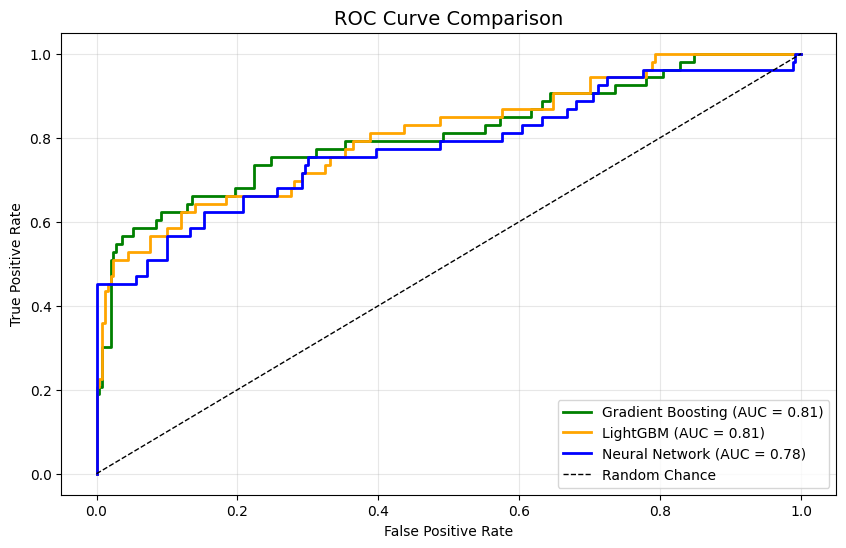

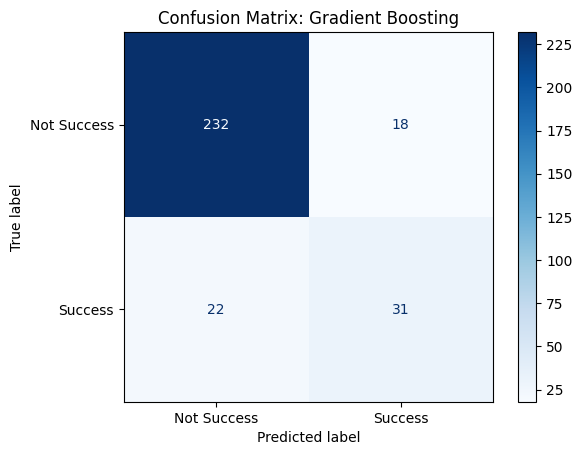

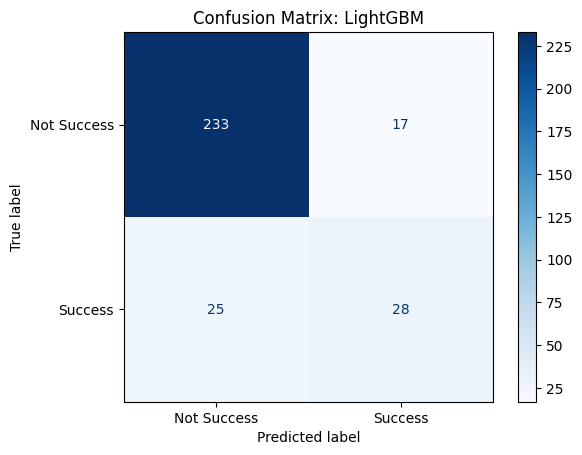

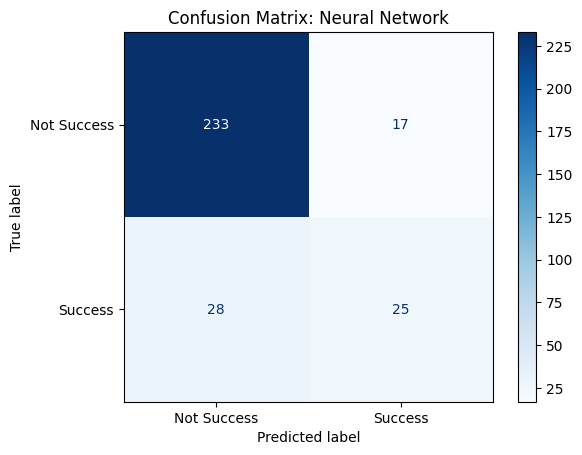

In [10]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train_resampled)
gb_predictions = gb_model.predict(X_test_scaled)
gb_report = classification_report(y_test, gb_predictions, output_dict=True)

# LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train_resampled)
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_report = classification_report(y_test, lgb_predictions, output_dict=True)

# Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train_resampled, epochs=20, batch_size=32, verbose=0)

nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
nn_report = classification_report(y_test, nn_predictions, output_dict=True)

# Results Comparison
results = {
    "Model": ["Gradient Boosting", "LightGBM", "Neural Network"],
    "Accuracy": [
        gb_report['accuracy'],
        lgb_report['accuracy'],
        nn_report['accuracy']
    ],
    "Precision": [
        gb_report['macro avg']['precision'],
        lgb_report['macro avg']['precision'],
        nn_report['macro avg']['precision']
    ],
    "Recall": [
        gb_report['macro avg']['recall'],
        lgb_report['macro avg']['recall'],
        nn_report['macro avg']['recall']
    ],
    "F1-Score": [
        gb_report['macro avg']['f1-score'],
        lgb_report['macro avg']['f1-score'],
        nn_report['macro avg']['f1-score']
    ],
    "AUC": [
        roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, lgb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, nn_model.predict(X_test_scaled).ravel())
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

# Plotting ROC Curve
plt.figure(figsize=(10, 6))
for model, name, color in zip([gb_model, lgb_model],
                              ["Gradient Boosting", "LightGBM"],
                              ["green", "orange"]):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=2, color=color)

# Add Neural Network to ROC Curve
nn_pred_proba = nn_model.predict(X_test_scaled).ravel()
fpr, tpr, _ = roc_curve(y_test, nn_pred_proba)
auc = roc_auc_score(y_test, nn_pred_proba)
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc:.2f})', linewidth=2, color='blue')

# Add Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Confusion Matrices
for model, name in zip([gb_model, lgb_model], ["Gradient Boosting", "LightGBM"]):
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues', display_labels=["Not Success", "Success"])
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# Confusion Matrix for Neural Network
nn_disp = ConfusionMatrixDisplay.from_predictions(y_test, nn_predictions, cmap='Blues', display_labels=["Not Success", "Success"])
plt.title('Confusion Matrix: Neural Network')
plt.show()

### Feature Importance

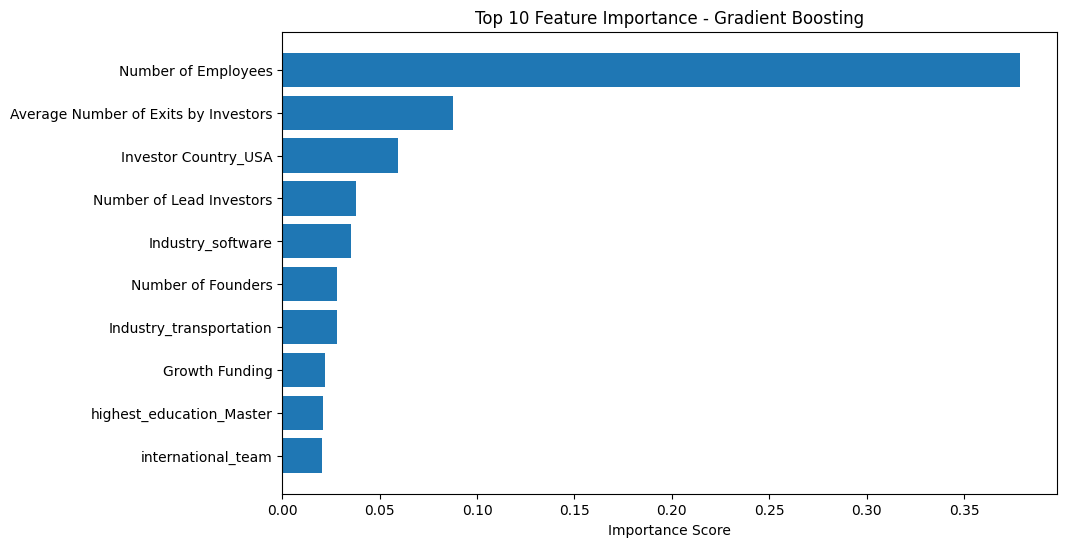

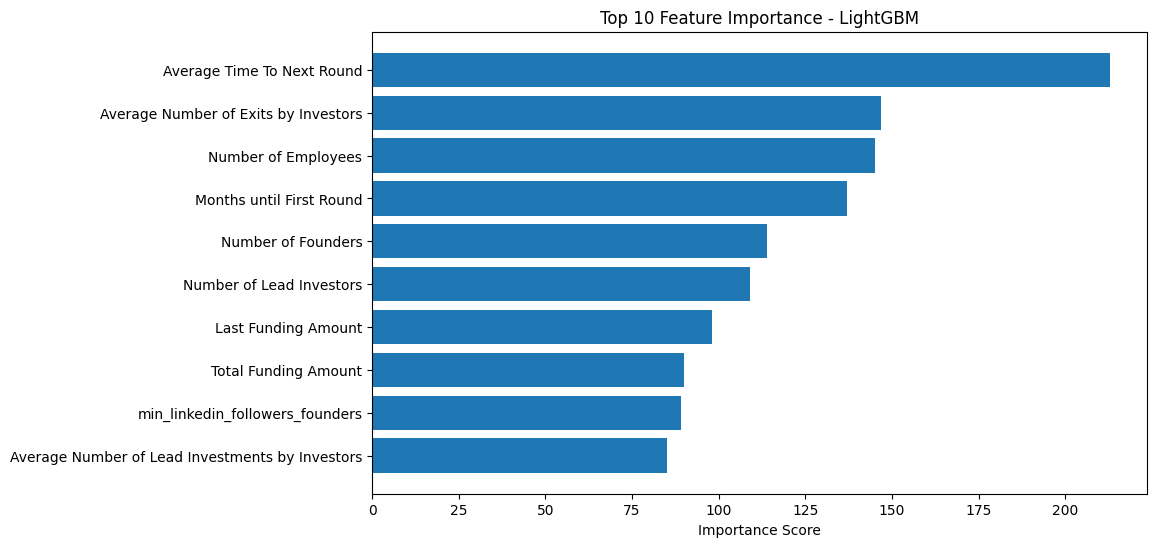

In [13]:
# Feature Importance Visualization (Top 10 Features)
def plot_top_feature_importance(model, feature_names, model_name, top_n=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'feature_importance_'):
        importances = model.feature_importance_()
    else:
        print(f"{model_name} does not support feature importance.")
        return

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.show()

# Plot top 10 feature importance for each model
feature_names = X.columns
plot_top_feature_importance(gb_model, feature_names, "Gradient Boosting")
plot_top_feature_importance(lgb_model, feature_names, "LightGBM")